In [173]:

import time
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate


BLOCK_SIZE = 64
NUM_ITERATIONS = 8
EPS = 10e-6

In [175]:
@cuda.jit
def gpu_vec_sum(vec, res):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * BLOCK_SIZE
    if idx < vec.shape[0]:
        res[0] += vec[idx]

In [177]:
def cpu_vec_sum(vec):
    return np.sum(vec)

In [179]:
def calculation():
    rows = []
    vec_size_min = 1_000
    vec_size_max = 1_000_000
    vec_size_interval = 50_000
    
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        cpu_time_sum = 0.
        gpu_time_sum = 0.
        
        for _ in range(NUM_ITERATIONS):
            vec = np.ones(vec_size)
            res = np.zeros(1, dtype=np.int32)

            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)

            # GPU computation
            start = time.perf_counter()  
            grid_size = (vec_size + TPB - 1) // BLOCK_SIZE  # Расчет количества блоков
            gpu_vec_sum[grid_size, TPB](d_vec, d_res)
            cuda.synchronize() 
            gpu_time_sum += time.perf_counter() - start
            res = d_res.copy_to_host()

            # CPU
            start = time.perf_counter()
            real_res = cpu_vec_sum(vec)
            cpu_time_sum += time.perf_counter() - start

        # Store average times per iteration
        row = [vec_size, cpu_time_sum / ITER, gpu_time_sum / ITER] 
        rows.append(row)

    # Print results
    print(tabulate(rows, headers=['Vector Size', 'CPU Time (ms)', 'GPU Time (ms)']))
    return rows

In [185]:
def plots(vec_array, cpu_time_array, gpu_time_array, acceleration_array):
    # график времени работы программы на CPU
    plt.figure()
    plt.title("Время работы на CPU")
    plt.plot(vec_array, cpu_time_array)
    plt.xlabel("Размер вектора")
    plt.ylabel("Время, сек")
    plt.grid()

    # график времени работы программы на GPU
    plt.figure()
    plt.title("Время работы на GPU")
    plt.plot(vec_array, gpu_time_array)
    plt.xlabel("Размер вектора")
    plt.ylabel("Время, сек")
    plt.grid()

    # график ускорения вычислений на GPU относительно CPU
    plt.figure()
    plt.title("Ускорение на GPU относительно CPU")
    plt.plot(vec_array, acceleration_array)
    plt.xlabel("Размер вектора")
    plt.ylabel("Ускорение, раз")
    plt.grid()


  Vector Size    CPU Time (ms)    GPU Time (ms)
-------------  ---------------  ---------------
         1000      1.6975e-05       0.000327125
        51000      5.19125e-05      0.00114645
       101000      4.54875e-05      0.00141596
       151000      8.4575e-05       0.00100231
       201000      0.00013495       0.0014149
       251000      0.00010055       0.000666237
       301000      0.000122688      0.000870562
       351000      0.000136313      0.0010479
       401000      0.000342175      0.00107838
       451000      0.000403638      0.000987725
       501000      0.00040845       0.00131904
       551000      0.000493537      0.00119773
       601000      0.000403125      0.00180061
       651000      0.000616812      0.00177529
       701000      0.00054545       0.00616809
       751000      0.000495513      0.000796038
       801000      0.0005882        0.00066865
       851000      0.000338537      0.000525075
       901000      0.000360862      0.000548288
      

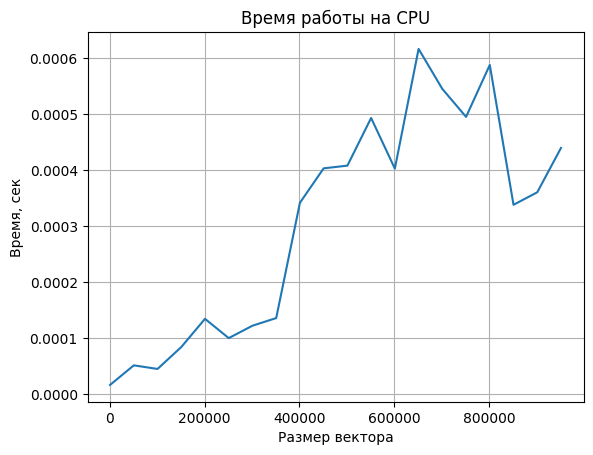

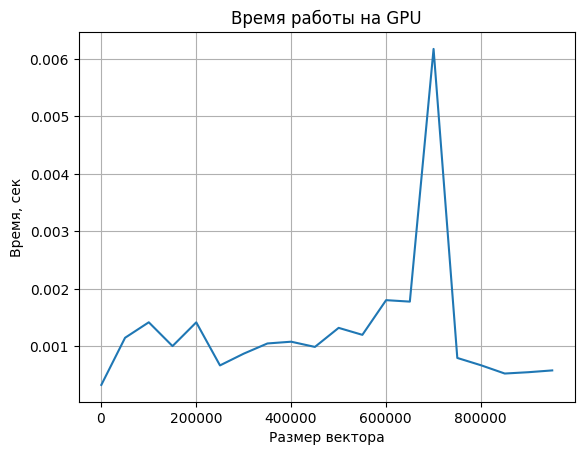

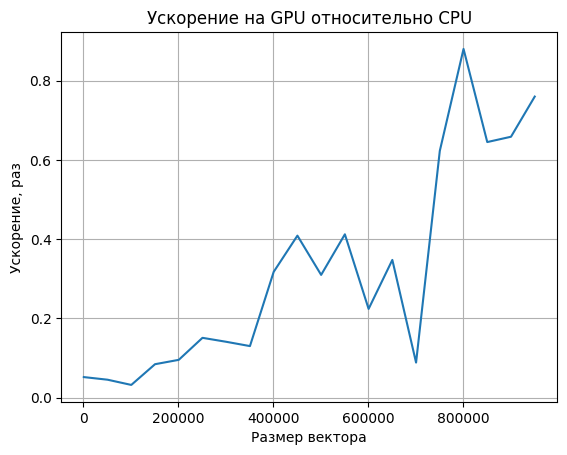

In [187]:

output_data = calculation()

# for plots
vec_array = list(map(lambda x: x[0], output_data))
cpu_time_array = list(map(lambda x: x[1], output_data))
gpu_time_array = list(map(lambda x: x[2], output_data))
acceleration_array = list(map(lambda x: x[1] / (x[2] if x[2] > EPS else EPS), output_data))

plots(vec_array, cpu_time_array, gpu_time_array, acceleration_array)